In [1]:
import sns
from sklearn.neighbors import BallTree
import geopandas as gpd
import numpy as np
import concurrent.futures
import math
# from distance_calculations import calculate_distances_chunk
# from distance_calculations import find_nearest_area_codes
import os
import sqlite3
from tqdm import tqdm
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split


C:\Users\Eliya\anaconda3\lib\site-packages\geopandas\_compat.py:111: UserWarning: The Shapely GEOS version (3.11.3-CAPI-1.17.3) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
df_encoded = pd.read_csv("data_encoded.csv")


In [3]:
features_important_RFC= ['MIN_TEMP', 'AVG_TEMP', 'MAX_TEMP', 'distance_to_nearest_population', 'distance_to_nearest_powerline_km', 'DISCOVERY_DOY', 'distance_to_nearest_railroad_km', 'distance_to_nearest_nature_km', 'distance_to_nearest_campground_km', 'distance_to_nearest_school_km', 'STAT_CAUSE_DESCR']
df_encoded = df_encoded[features_important_RFC]

train_df, test_df = train_test_split(df_encoded, test_size=0.2, random_state=42)

#calculate the mean of none values in the train set:
# mean_time_to_cont = train_df['TIME_TO_CONT_MINUTES'].mean()
mean_max_temp = train_df['MAX_TEMP'].mean()
mean_min_temp = train_df['MIN_TEMP'].mean()
# mean_prcp = train_df['PRCP'].mean()
mean_avg_temp = train_df['AVG_TEMP'].mean()
# mean_fire_size = train_df['FIRE_SIZE'].mean()

#apply to train and test:
# train_df['TIME_TO_CONT_MINUTES'] = train_df['TIME_TO_CONT_MINUTES'].fillna(mean_time_to_cont)
train_df['MAX_TEMP'] = train_df['MAX_TEMP'].fillna(mean_max_temp)
train_df['MIN_TEMP'] = train_df['MIN_TEMP'].fillna(mean_min_temp)
# train_df['PRCP'] = train_df['PRCP'].fillna(mean_min_temp)
train_df['AVG_TEMP']= train_df['AVG_TEMP'].fillna(mean_avg_temp)
# train_df['FIRE_SIZE'] = train_df['FIRE_SIZE'].fillna(mean_fire_size)

# test_df['TIME_TO_CONT_MINUTES'] = test_df['TIME_TO_CONT_MINUTES'].fillna(mean_time_to_cont)
test_df['MAX_TEMP'] = test_df['MAX_TEMP'].fillna(mean_max_temp)
test_df['MIN_TEMP'] = test_df['MIN_TEMP'].fillna(mean_min_temp)
# test_df['PRCP'] = test_df['PRCP'].fillna(mean_prcp)
test_df['AVG_TEMP']= test_df['AVG_TEMP'].fillna(mean_avg_temp)
# test_df['FIRE_SIZE'] = test_df['FIRE_SIZE'].fillna(mean_fire_size)

In [4]:
print(test_df.isnull().sum() )

MIN_TEMP                             0
AVG_TEMP                             0
MAX_TEMP                             0
distance_to_nearest_population       0
distance_to_nearest_powerline_km     0
DISCOVERY_DOY                        0
distance_to_nearest_railroad_km      0
distance_to_nearest_nature_km        0
distance_to_nearest_campground_km    0
distance_to_nearest_school_km        0
STAT_CAUSE_DESCR                     0
dtype: int64


In [5]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt


# df_encoded = df_encoded.drop(columns=df_encoded.columns[df_encoded.columns.str.startswith('NWGC')])
# df_encoded = df_encoded.drop(columns=df_encoded.columns[df_encoded.columns.str.startswith('nearest_holiday')])

# features_important_RFC= ['STAT_CAUSE_DESCR', 'MIN_TEMP', 'AVG_TEMP', 'MAX_TEMP', 'distance_to_nearest_population', 'distance_to_nearest_powerline_km', 'DISCOVERY_DOY', 'distance_to_nearest_railroad_km', 'distance_to_nearest_nature_km', 'distance_to_nearest_campground_km', 'distance_to_nearest_school_km']
# df_encoded = df_encoded[features_important_RFC]

# train_df, test_df = train_test_split(df_encoded, test_size=0.2, random_state=42)

# Assuming train_df and test_df are defined elsewhere and contain the necessary data
X_train = train_df.drop(columns=['STAT_CAUSE_DESCR'])
y_train = train_df['STAT_CAUSE_DESCR']

X_test = test_df.drop(columns=['STAT_CAUSE_DESCR'])
y_test = test_df['STAT_CAUSE_DESCR']

# Gradient Boosting Classifier
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=1, random_state=42, verbose=1)
gbc.fit(X_train, y_train)
# Predict class probabilities for ROC AUC score calculation
gbc_prob = gbc.predict_proba(X_test)
# Calculate ROC AUC score for multi-class using One-vs-Rest (OvR) approach
gbc_score = roc_auc_score(y_test, gbc_prob, multi_class='ovr')

# Random Forest Classifier
rfc = RandomForestClassifier(n_estimators=100, random_state=42, verbose=1)
rfc.fit(X_train, y_train)
# Predict class probabilities for ROC AUC score calculation
rfc_prob = rfc.predict_proba(X_test)
# Calculate ROC AUC score for multi-class using One-vs-Rest (OvR) approach
rfc_score = roc_auc_score(y_test, rfc_prob, multi_class='ovr')

print(f"Gradient Boosting Classifier ROC AUC score: {gbc_score:.2f}")
print(f"Random Forest Classifier ROC AUC score: {rfc_score:.2f}")

      Iter       Train Loss   Remaining Time 
         1           1.9581            9.91m
         2           1.9338            9.70m
         3           1.9145            9.60m
         4           1.8973            9.50m
         5           1.8842            9.36m
         6           1.8721            9.23m
         7           1.8613            9.09m
         8           1.8519            9.00m
         9           1.8436            8.89m
        10           1.8368            8.80m
        20           1.7829            7.78m
        30           1.7528            6.81m
        40           1.7318            5.84m
        50           1.7174            4.86m
        60           1.7069            3.90m
        70           1.6990            2.93m
        80           1.6929            1.97m
        90           1.6878           59.20s
       100           1.6839            0.00s


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  1.8min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.1s


Gradient Boosting Classifier ROC AUC score: 0.73
Random Forest Classifier ROC AUC score: 0.74


In [6]:
from sklearn.metrics import classification_report
print(classification_report(y_test,gbc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.38      0.04      0.08     18506
           1       0.31      0.06      0.10      5067
           2       0.00      0.00      0.00      4095
           3       0.37      0.81      0.51     28523
           4       0.17      0.00      0.00      9984
           5       0.00      0.00      0.00       781
           6       0.58      0.78      0.67     18573
           7       0.31      0.34      0.33     21742
           8       0.00      0.00      0.00       974
           9       0.30      0.06      0.10      2230
          10       0.00      0.00      0.00      3568
          11       0.00      0.00      0.00       242

    accuracy                           0.40    114285
   macro avg       0.20      0.17      0.15    114285
weighted avg       0.34      0.40      0.32    114285



C:\Users\Eliya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Eliya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Eliya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [7]:
print(classification_report(y_test,rfc.predict(X_test)))

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.1s


              precision    recall  f1-score   support

           0       0.42      0.29      0.34     18506
           1       0.45      0.16      0.24      5067
           2       0.36      0.08      0.13      4095
           3       0.42      0.72      0.53     28523
           4       0.34      0.11      0.17      9984
           5       0.67      0.30      0.41       781
           6       0.65      0.81      0.72     18573
           7       0.38      0.39      0.39     21742
           8       0.28      0.01      0.01       974
           9       0.52      0.15      0.23      2230
          10       0.20      0.01      0.01      3568
          11       0.43      0.02      0.05       242

    accuracy                           0.46    114285
   macro avg       0.43      0.25      0.27    114285
weighted avg       0.44      0.46      0.42    114285



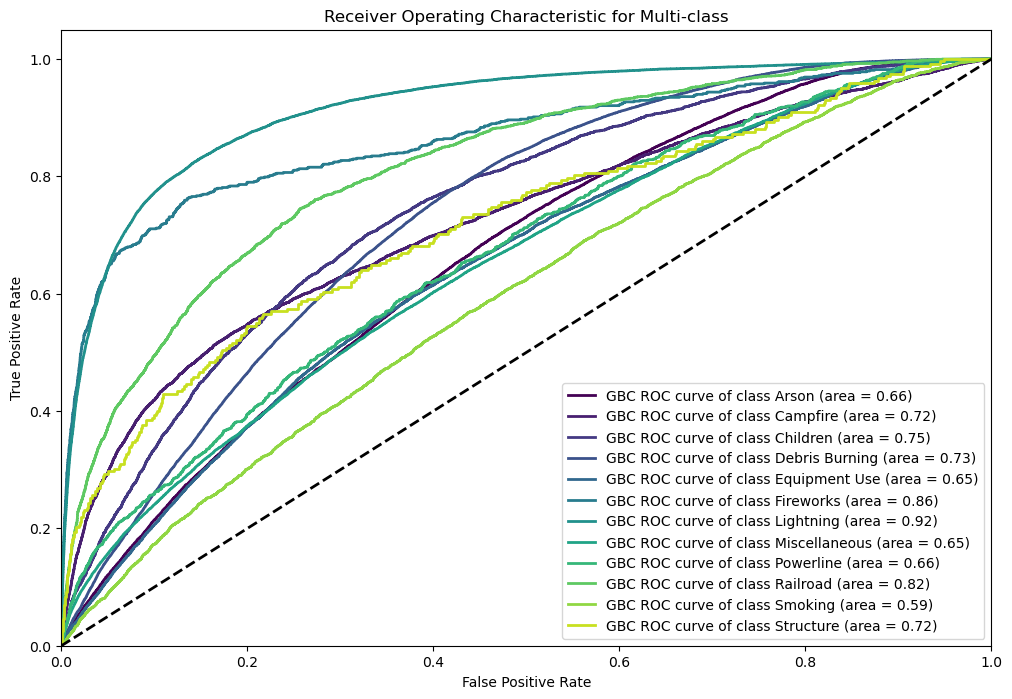

In [8]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

# Assuming `y_test` is your test labels and `gbc_prob`, `rfc_prob` are the prediction probabilities from your models
# Classes dictionary as provided
classes = {0: 'Arson', 1: 'Campfire', 2: 'Children', 3: 'Debris Burning', 4: 'Equipment Use', 5: 'Fireworks', 6: 'Lightning', 7: 'Miscellaneous', 8: 'Powerline', 9: 'Railroad', 10: 'Smoking', 11: 'Structure'}

# Binarize the output
y_test_binarized = label_binarize(y_test, classes=list(classes.keys()))

n_classes = len(classes)

# Initialize dictionaries to hold the ROC curve data
fpr = dict()
tpr = dict()
roc_auc = dict()

# Calculate ROC and AUC for each class for each model
for i in range(n_classes):
    fpr["GBC", i], tpr["GBC", i], _ = roc_curve(y_test_binarized[:, i], gbc_prob[:, i])
    roc_auc["GBC", i] = auc(fpr["GBC", i], tpr["GBC", i])

# Plotting the ROC curves
plt.figure(figsize=(12, 8))

colors = [plt.cm.viridis(i / float(n_classes)) for i in range(n_classes)]

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr["GBC", i], tpr["GBC", i], color=color, lw=2,
             label='GBC ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classes[i], roc_auc["GBC", i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multi-class')
plt.legend(loc="lower right", prop={'size': 10})
plt.show()


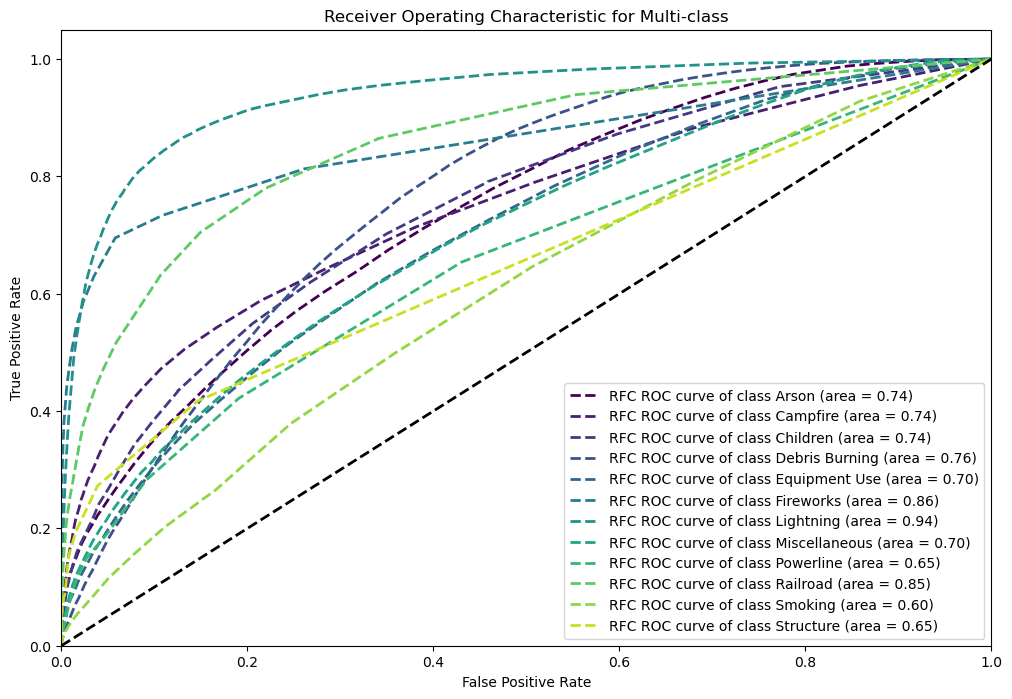

In [9]:

# Assuming `y_test` is your test labels and `gbc_prob`, `rfc_prob` are the prediction probabilities from your models
# Classes dictionary as provided
classes = {0: 'Arson', 1: 'Campfire', 2: 'Children', 3: 'Debris Burning', 4: 'Equipment Use', 5: 'Fireworks', 6: 'Lightning', 7: 'Miscellaneous', 8: 'Powerline', 9: 'Railroad', 10: 'Smoking', 11: 'Structure'}

# Binarize the output
y_test_binarized = label_binarize(y_test, classes=list(classes.keys()))

n_classes = len(classes)

# Initialize dictionaries to hold the ROC curve data
fpr = dict()
tpr = dict()
roc_auc = dict()


# Calculate ROC and AUC for each class for each model
for i in range(n_classes):
    fpr["RFC", i], tpr["RFC", i], _ = roc_curve(y_test_binarized[:, i], rfc_prob[:, i])
    roc_auc["RFC", i] = auc(fpr["RFC", i], tpr["RFC", i])

# Plotting the ROC curves
plt.figure(figsize=(12, 8))

colors = [plt.cm.viridis(i / float(n_classes)) for i in range(n_classes)]

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr["RFC", i], tpr["RFC", i], color=color, lw=2, linestyle='--',
             label='RFC ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classes[i], roc_auc["RFC", i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multi-class')
plt.legend(loc="lower right", prop={'size': 10})
plt.show()


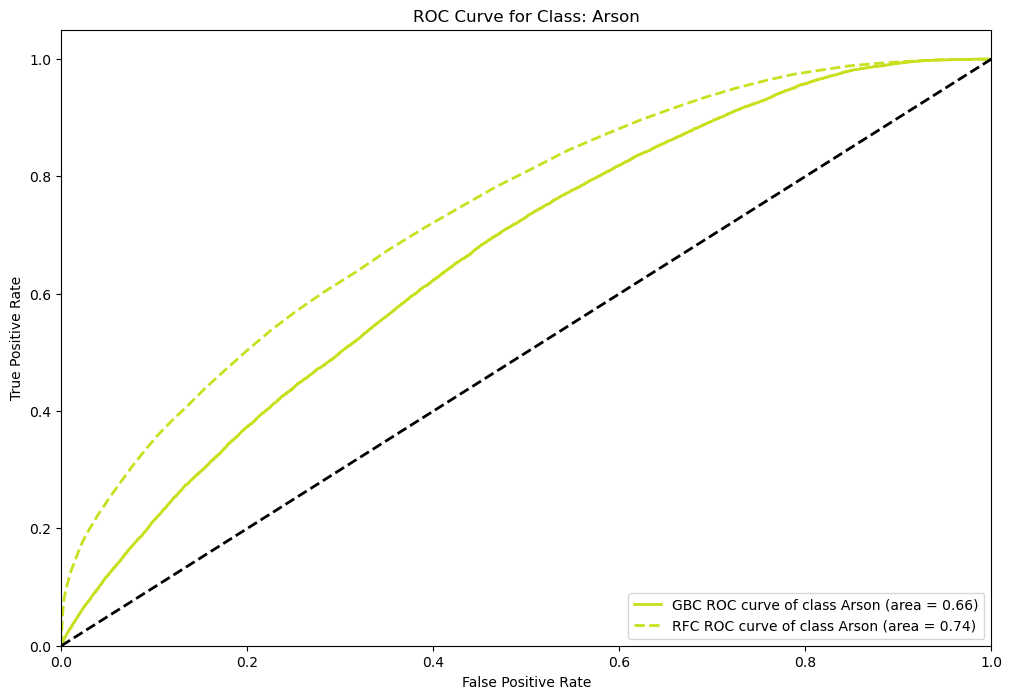

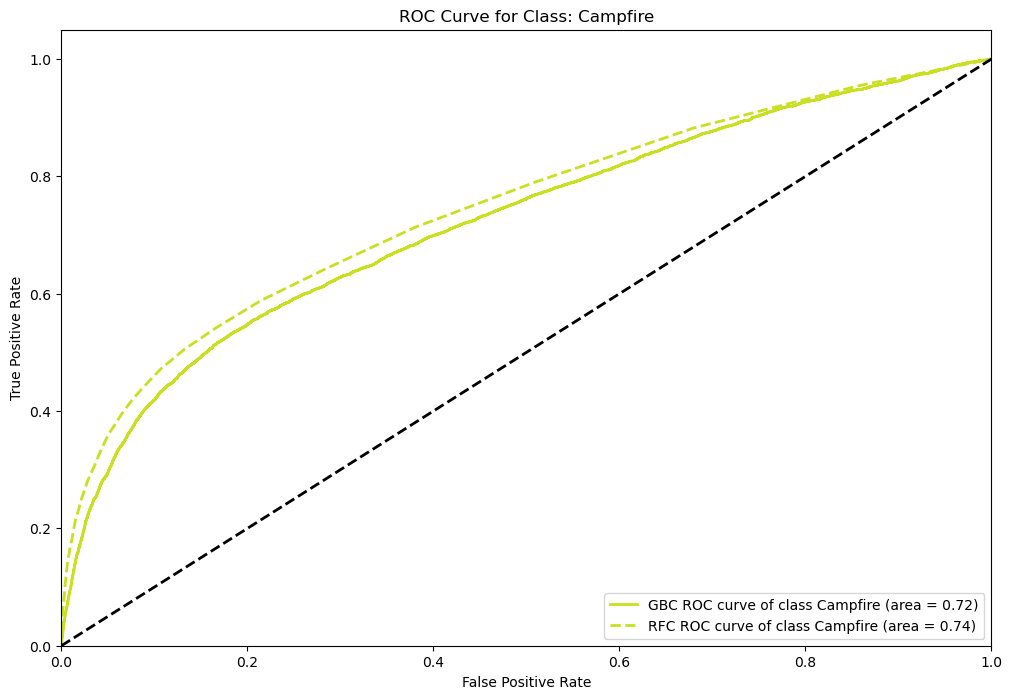

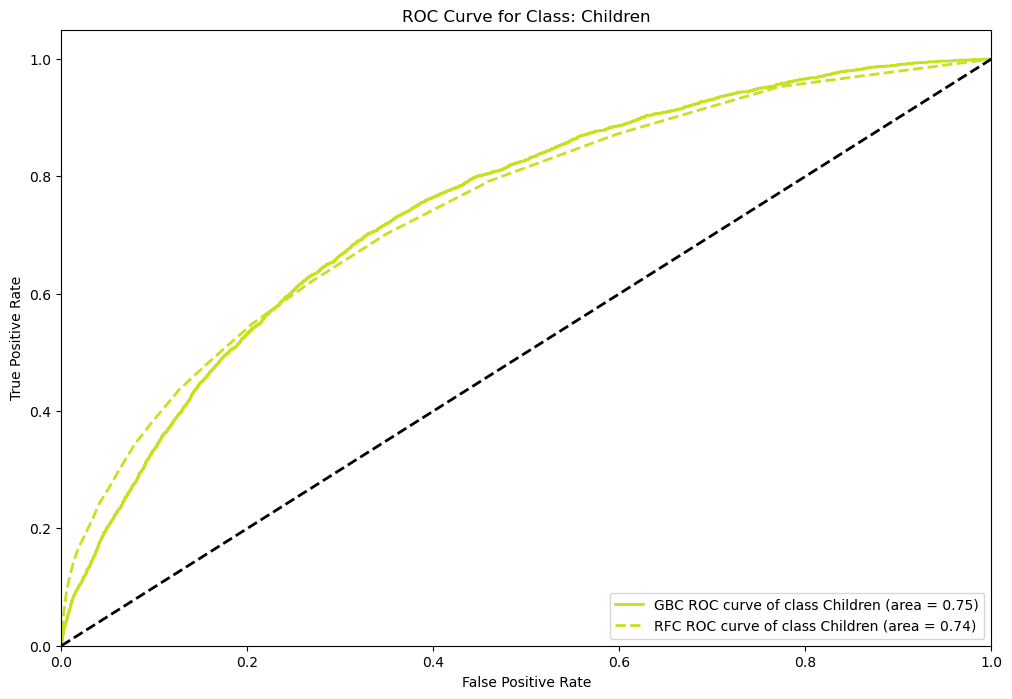

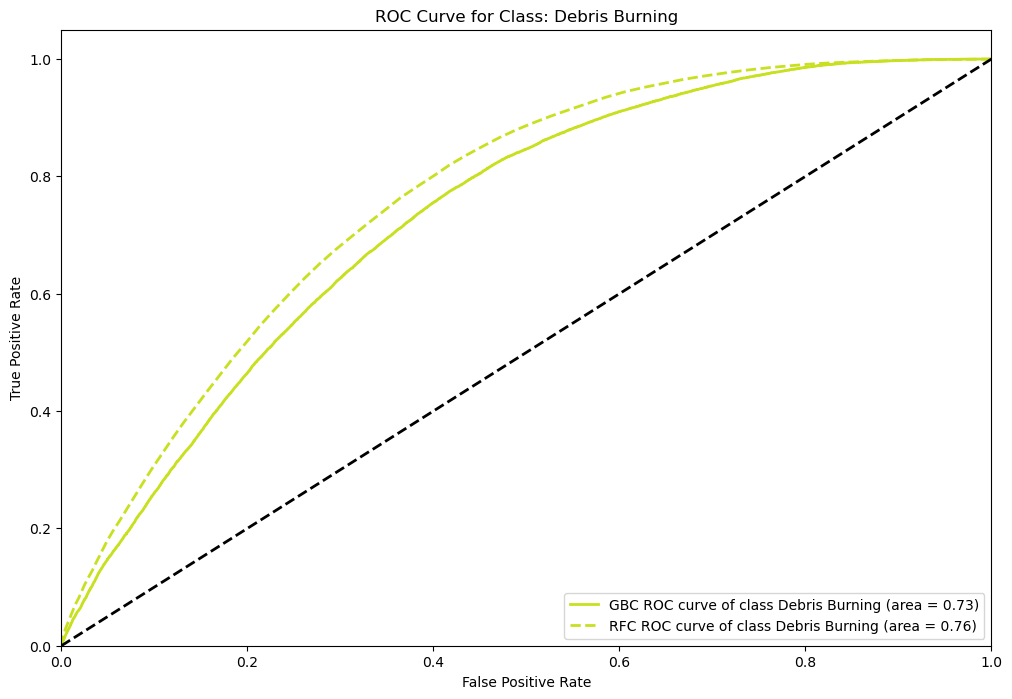

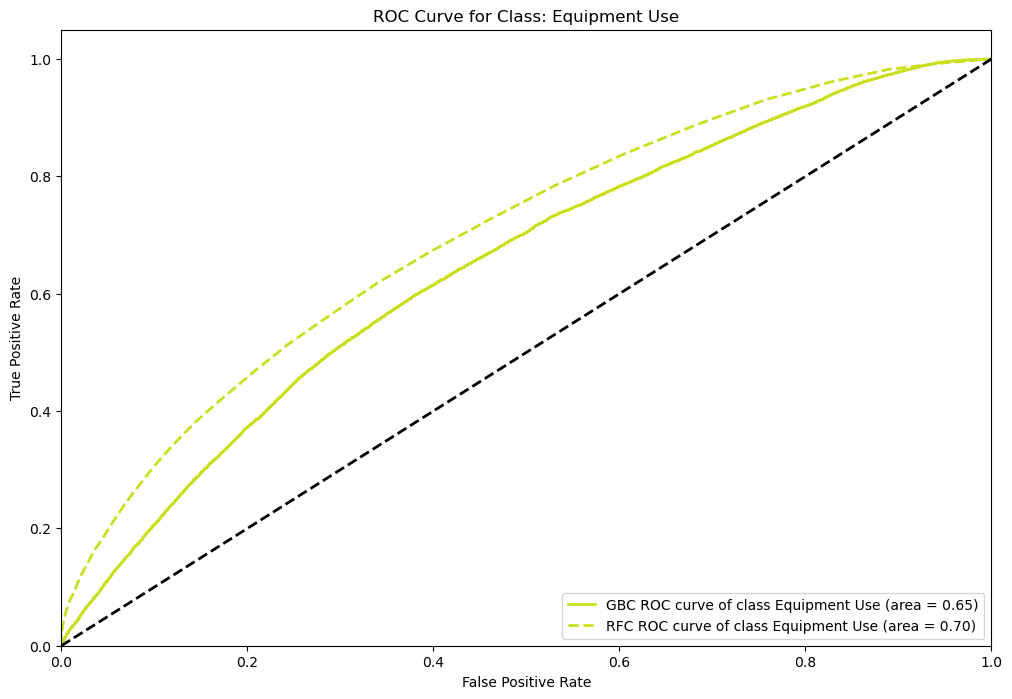

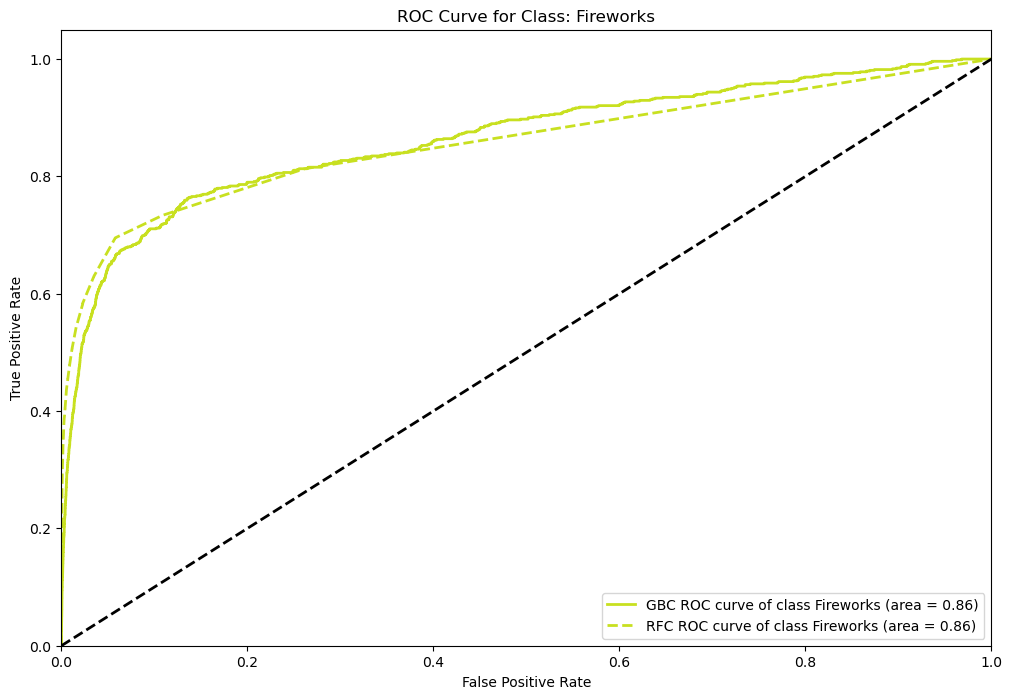

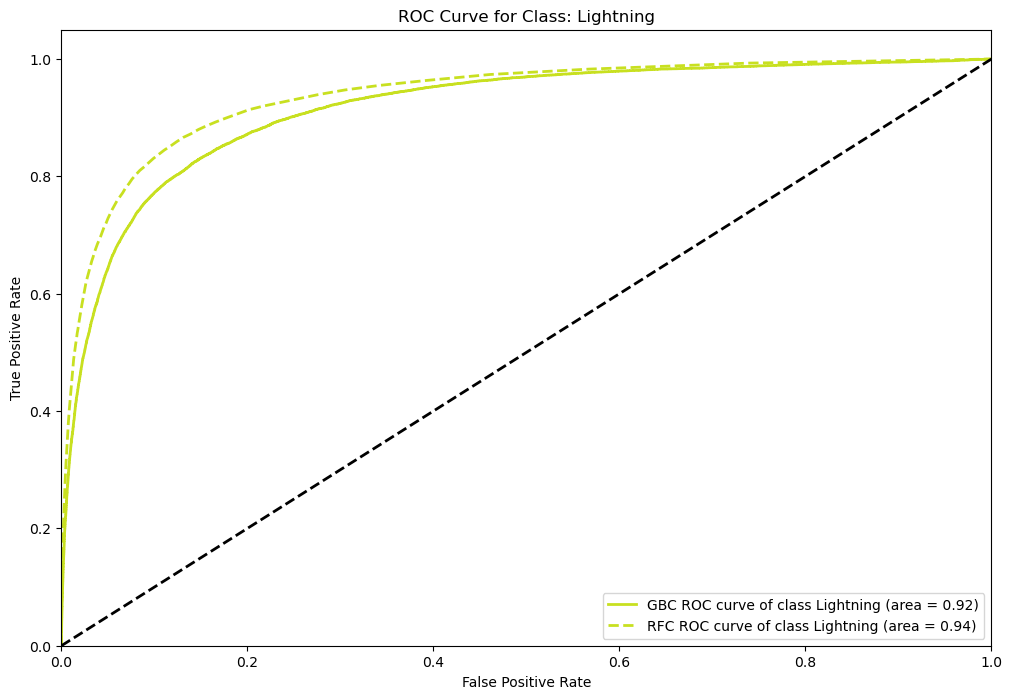

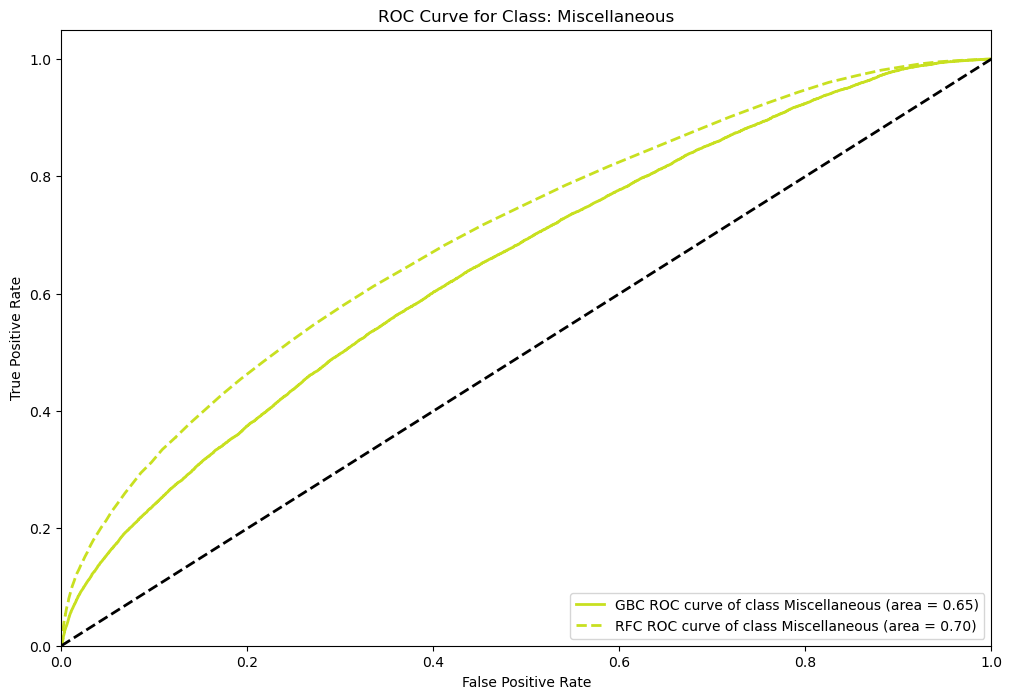

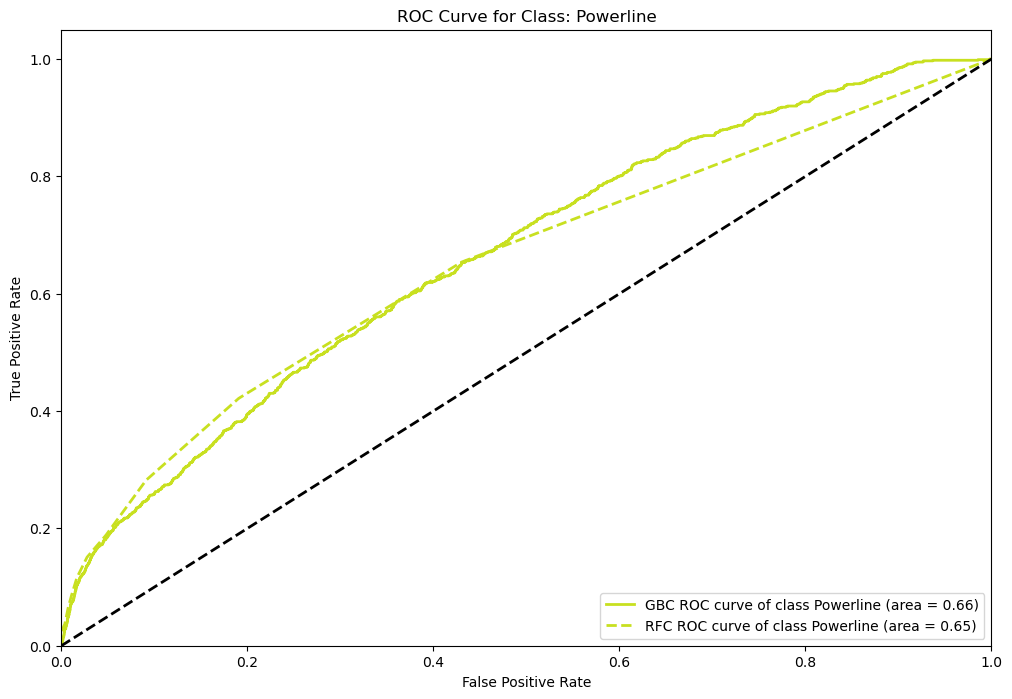

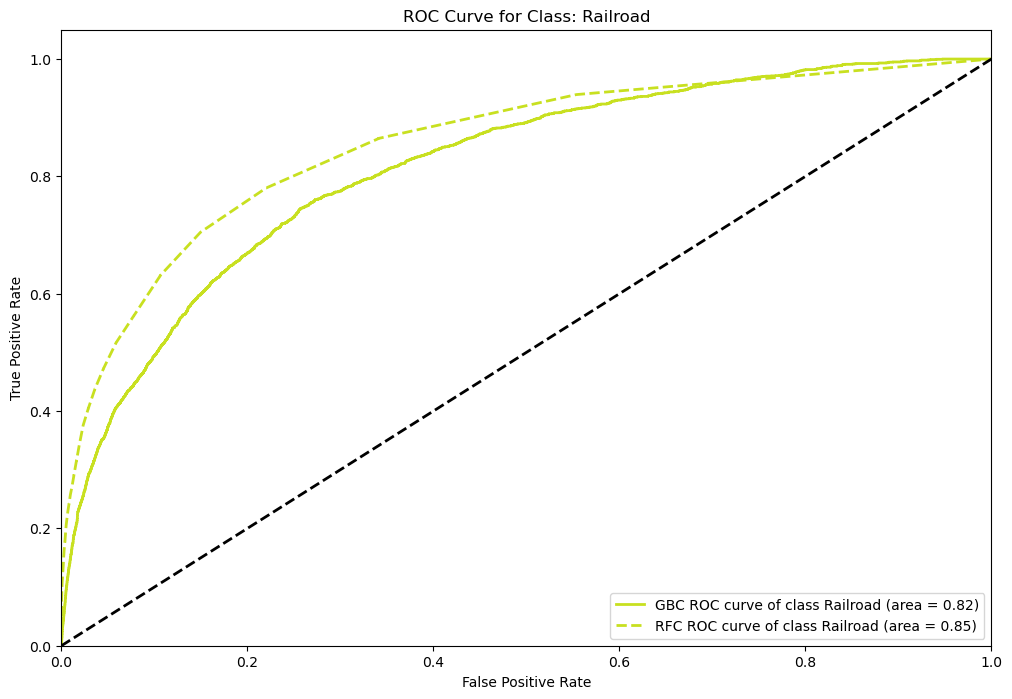

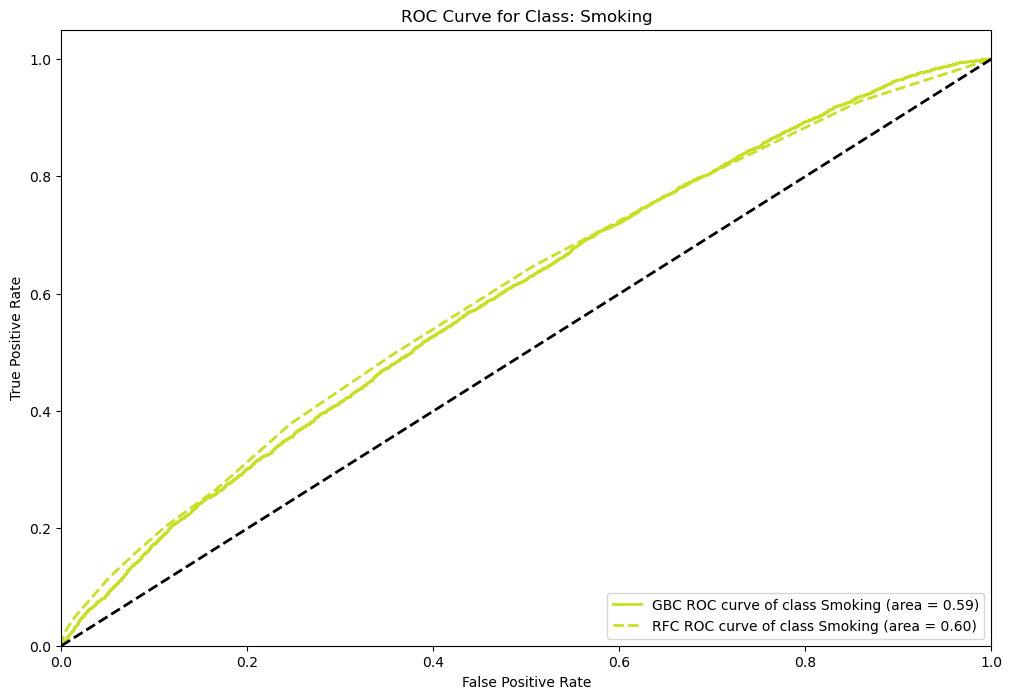

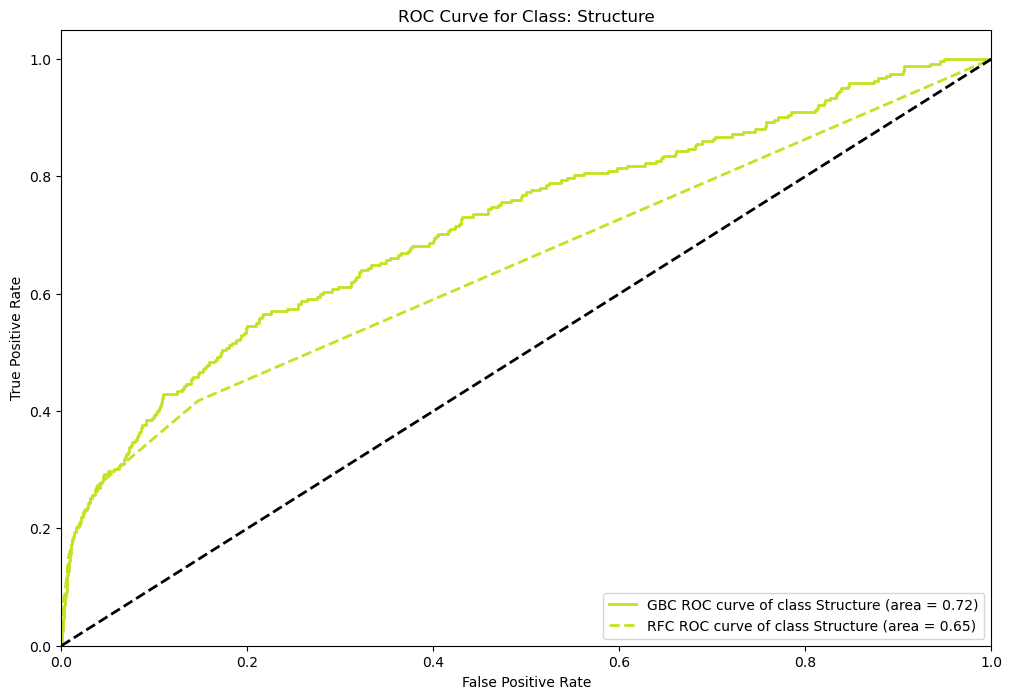

In [10]:

# Assuming `y_test` is your test labels and `gbc_prob`, `rfc_prob` are the prediction probabilities from your models
# Classes dictionary as provided
classes = {0: 'Arson', 1: 'Campfire', 2: 'Children', 3: 'Debris Burning', 4: 'Equipment Use', 5: 'Fireworks', 6: 'Lightning', 7: 'Miscellaneous', 8: 'Powerline', 9: 'Railroad', 10: 'Smoking', 11: 'Structure'}

# Binarize the output
y_test_binarized = label_binarize(y_test, classes=list(classes.keys()))

n_classes = len(classes)

# Initialize dictionaries to hold the ROC curve data
fpr = dict()
tpr = dict()
roc_auc = dict()

# Calculate ROC and AUC for each class for each model
for i in range(n_classes):
    fpr["GBC", i], tpr["GBC", i], _ = roc_curve(y_test_binarized[:, i], gbc_prob[:, i])
    roc_auc["GBC", i] = auc(fpr["GBC", i], tpr["GBC", i])
    fpr["RFC", i], tpr["RFC", i], _ = roc_curve(y_test_binarized[:, i], rfc_prob[:, i])
    roc_auc["RFC", i] = auc(fpr["RFC", i], tpr["RFC", i])
        
for i in range(n_classes):
    # Plotting the ROC curves
    plt.figure(figsize=(12, 8))
    
    colors = [plt.cm.viridis(i / float(n_classes)) for i in range(n_classes)]

    plt.plot(fpr["GBC", i], tpr["GBC", i], color=color, lw=2,
             label='GBC ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classes[i], roc_auc["GBC", i]))
    plt.plot(fpr["RFC", i], tpr["RFC", i], color=color, lw=2, linestyle='--',
                label='RFC ROC curve of class {0} (area = {1:0.2f})'
                ''.format(classes[i], roc_auc["RFC", i]))
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for Class: {classes[i]}')
    plt.legend(loc="lower right")
    plt.show()


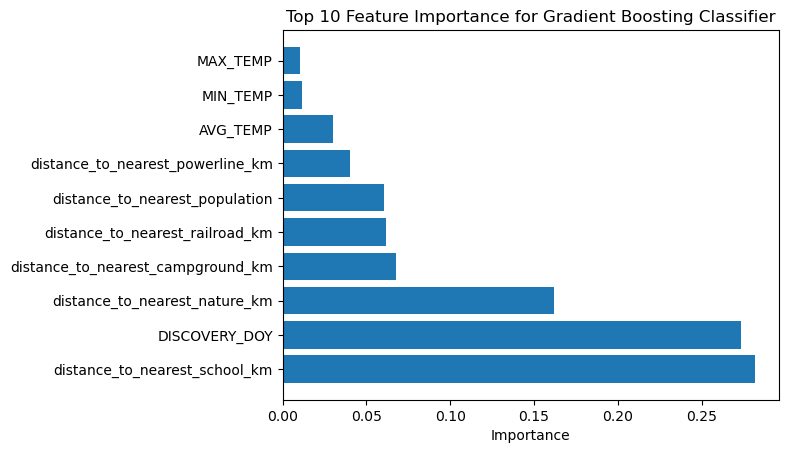

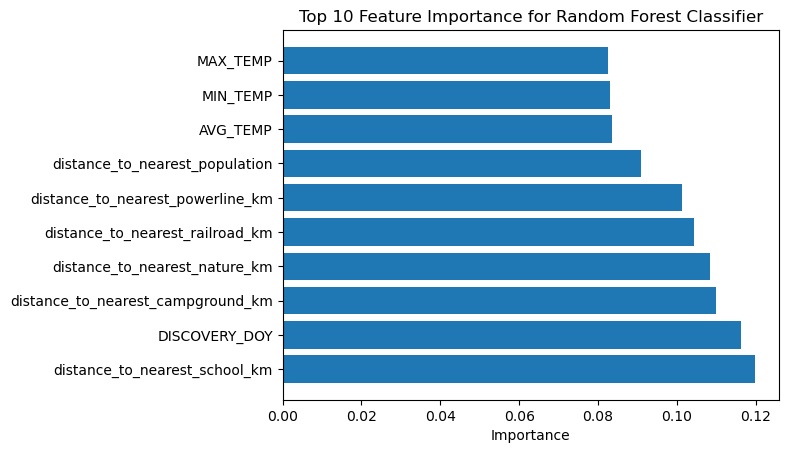

In [11]:
#Feature importance for both models

# Gradient Boosting Classifier
gbc_feature_importance = gbc.feature_importances_
gbc_feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': gbc_feature_importance})
gbc_feature_importance_df = gbc_feature_importance_df.sort_values(by='Importance', ascending=False)

#Plot the feature importance
fig, ax = plt.subplots()
ax.barh(gbc_feature_importance_df['Feature'][:10], gbc_feature_importance_df['Importance'][:10])
ax.set_xlabel('Importance')
ax.set_title('Top 10 Feature Importance for Gradient Boosting Classifier')
plt.show()


# Random Forest Classifier
rfc_feature_importance = rfc.feature_importances_
rfc_feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': rfc_feature_importance})
rfc_feature_importance_df = rfc_feature_importance_df.sort_values(by='Importance', ascending=False)

#Plot the feature importance 
fig, ax = plt.subplots()
ax.barh(rfc_feature_importance_df['Feature'][:10], rfc_feature_importance_df['Importance'][:10])
ax.set_xlabel('Importance')
ax.set_title('Top 10 Feature Importance for Random Forest Classifier')
plt.show() 

In [12]:
print(sum(rfc_feature_importance_df['Importance']))

1.0000000000000002


In [13]:
rfc_feature_importance_df['Importance']


9    0.119789
5    0.116194
8    0.110014
7    0.108301
6    0.104396
4    0.101216
3    0.090966
1    0.083478
0    0.083135
2    0.082510
Name: Importance, dtype: float64

In [14]:
gbc_feature_importance_df['Importance']

9    0.281722
5    0.273678
7    0.162010
8    0.067532
6    0.061924
3    0.060621
4    0.040382
1    0.029882
0    0.011827
2    0.010422
Name: Importance, dtype: float64

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.0s


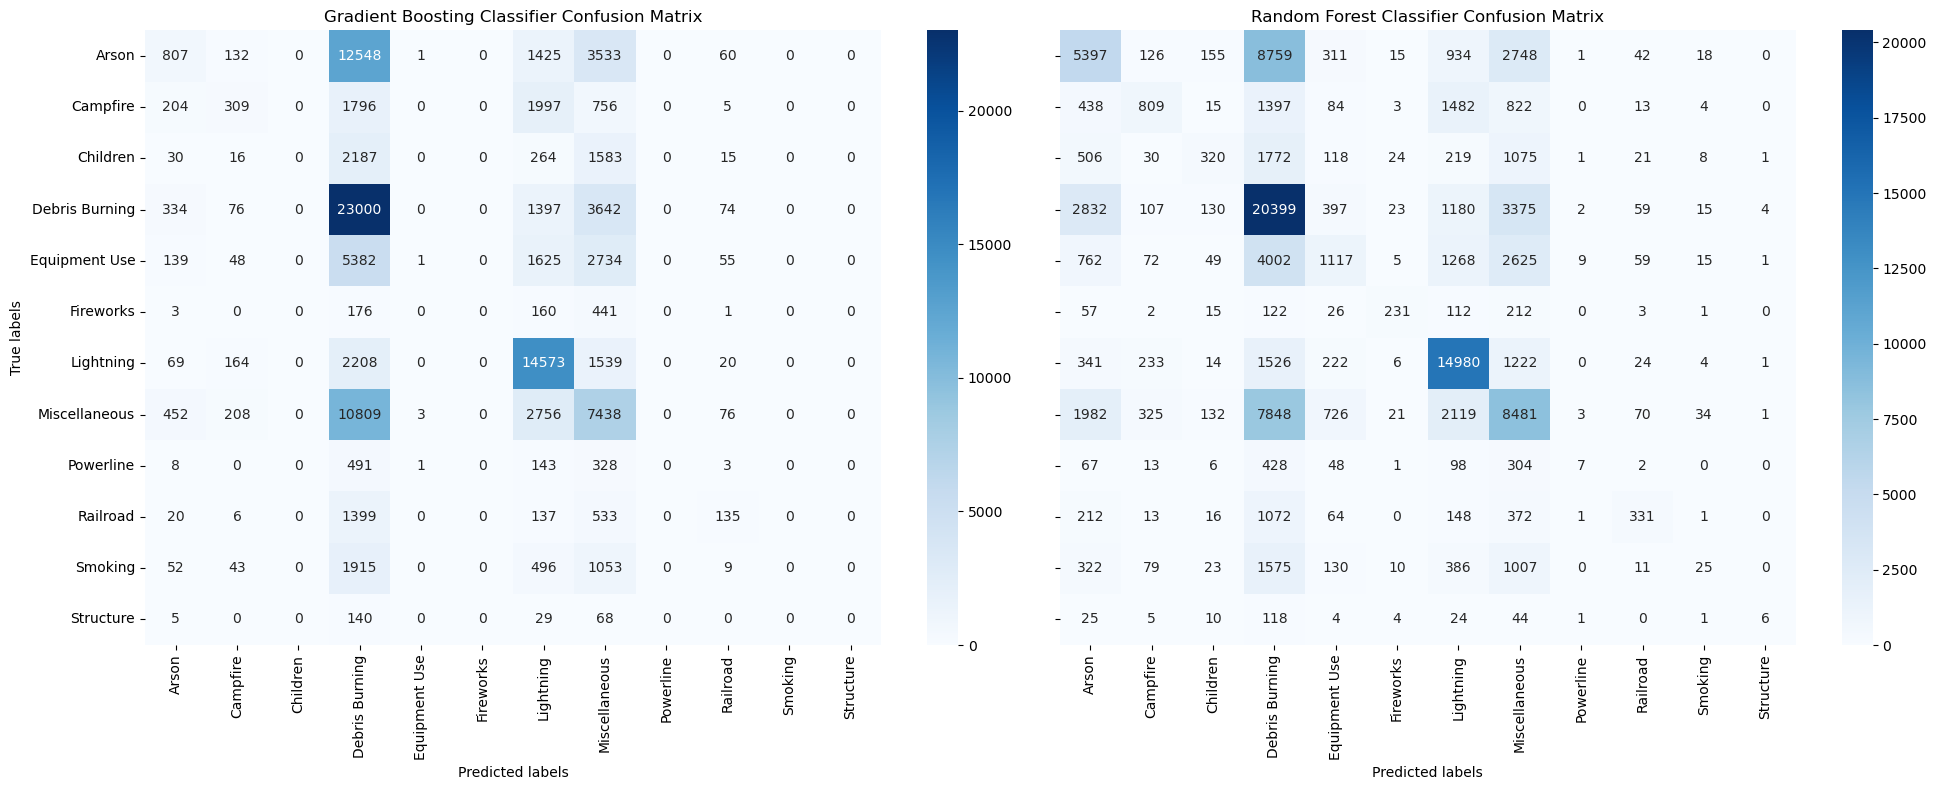

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

mapping_dict = {0: 'Arson', 1: 'Campfire', 2: 'Children', 3: 'Debris Burning',
 4: 'Equipment Use', 5: 'Fireworks', 6: 'Lightning', 7: 'Miscellaneous', 8: 'Powerline',
 9: 'Railroad', 10: 'Smoking', 11: 'Structure'}

# Assuming `gbc` and `rfc` are your trained models
# Assuming `X_test` and `y_test` are your test datasets
# Assuming `mapping_dict` is your mapping from integer labels back to string labels

# Generate predictions
gbc_predictions = gbc.predict(X_test)
rfc_predictions = rfc.predict(X_test)

# Convert integer predictions back to string labels using the mapping dictionary
gbc_predictions_strings = [mapping_dict[label] for label in gbc_predictions]
rfc_predictions_strings = [mapping_dict[label] for label in rfc_predictions]
y_test_strings = [mapping_dict[label] for label in y_test]  # Convert y_test to strings

# Compute confusion matrices with string labels
labels_list = list(mapping_dict.values())  # Get the list of original string labels
gbc_cm = confusion_matrix(y_test_strings, gbc_predictions_strings, labels=labels_list)
rfc_cm = confusion_matrix(y_test_strings, rfc_predictions_strings, labels=labels_list)

# Visualize the confusion matrices
fig, ax = plt.subplots(1, 2, figsize=(20, 8), sharey=True)

# Gradient Boosting Classifier Confusion Matrix
sns.heatmap(gbc_cm, annot=True, fmt="d", ax=ax[0], cmap='Blues', xticklabels=labels_list, yticklabels=labels_list)
ax[0].set_title('Gradient Boosting Classifier Confusion Matrix')
ax[0].set_xlabel('Predicted labels')
ax[0].set_ylabel('True labels')

# Random Forest Classifier Confusion Matrix
sns.heatmap(rfc_cm, annot=True, fmt="d", ax=ax[1], cmap='Blues', xticklabels=labels_list, yticklabels=labels_list)
ax[1].set_title('Random Forest Classifier Confusion Matrix')
ax[1].set_xlabel('Predicted labels')
# ax[1].set_ylabel('True labels')  # Optional, already set for ax[0] and shared Y axis

plt.tight_layout()
plt.show()



In [16]:
import numpy as np

# Function to calculate and print accuracy for each class
def print_class_accuracy(confusion_matrix, class_labels):
    print("Class-wise Accuracy:")
    for i, label in enumerate(class_labels):
        true_positives = confusion_matrix[i, i]
        total_instances = np.sum(confusion_matrix[i, :])
        if total_instances > 0:
            accuracy = true_positives / total_instances
            print(f"{label}: {accuracy:.2f}")
        else:
            print(f"{label}: No instances in the test set.")

# Assuming gbc_cm and rfc_cm are your confusion matrices from the previous step
# Assuming labels_list contains your class labels as strings

print("Gradient Boosting Classifier")
print_class_accuracy(gbc_cm, labels_list)
print("\nRandom Forest Classifier")
print_class_accuracy(rfc_cm, labels_list)


Gradient Boosting Classifier
Class-wise Accuracy:
Arson: 0.04
Campfire: 0.06
Children: 0.00
Debris Burning: 0.81
Equipment Use: 0.00
Fireworks: 0.00
Lightning: 0.78
Miscellaneous: 0.34
Powerline: 0.00
Railroad: 0.06
Smoking: 0.00
Structure: 0.00

Random Forest Classifier
Class-wise Accuracy:
Arson: 0.29
Campfire: 0.16
Children: 0.08
Debris Burning: 0.72
Equipment Use: 0.11
Fireworks: 0.30
Lightning: 0.81
Miscellaneous: 0.39
Powerline: 0.01
Railroad: 0.15
Smoking: 0.01
Structure: 0.02


In [17]:
from sklearn.metrics import precision_recall_curve
probas =  rfc.predict_proba(X_test)

precision, recall, _ = precision_recall_curve(y_test, probas[: ,1], pos_label="sick")
plt.plot(recall, precision, marker='.', label="rfc")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0,1])
plt.legend()
plt.title("Precision-Recall curve for a logistic regression model")
plt.show()

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.2s
C:\Users\Eliya\anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:837: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  y_true = y_true == pos_label


TypeError: 'bool' object is not subscriptable

In [ ]:
from sklearn.metrics import precision_recall_curve
probas =  gbc.predict_proba(X_test)

precision, recall, _ = precision_recall_curve(y_test, probas[: ,1], pos_label="sick")
plt.plot(recall, precision, marker='.', label="gbc")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0,1])
plt.legend()
plt.title("Precision-Recall curve for a logistic regression model")
plt.show()

In [ ]:
import optuna
from sklearn.model_selection import cross_val_score
def objective(trial):
    
    params={}
    params['n_estimators'] = trial.suggest_int('n_estimators', 2, 1000)
    params['max_depth'] = trial.suggest_int('max_depth', 5, 15)
    params['criterion'] = trial.suggest_categorical('criterion',['gini','entropy'])
    model = RandomForestClassifier(random_state=50, **params)
    res = cross_val_score(model, X_train, y_train, scoring='f1_macro',cv=5).mean()
    return res

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

trial = study.best_trial

print('Best score: {}'.format(trial.value))


In [ ]:
import optuna
from sklearn.model_selection import cross_val_score
def objective(trial):
    
    params={}
    params['n_estimators'] = trial.suggest_int('n_estimators', 2, 100)
    params['max_depth'] = trial.suggest_int('max_depth', 5, 15)
    params['criterion'] = trial.suggest_categorical('criterion',['gini','entropy'])
    model = RandomForestClassifier(random_state=50, **params)
    res = cross_val_score(model, X_train, y_train, scoring='f1_macro',cv=5).mean()
    return res

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

trial = study.best_trial

print('Best score: {}'.format(trial.value))


In [ ]:
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier

def objective(trial):

    params = {}
    params['n_estimators'] = trial.suggest_int('n_estimators', 10, 100)  # Adjust range for gradient boosting
    params['learning_rate'] = trial.suggest_float('learning_rate', 0.01, 1.0)  # Add learning rate
    params['max_depth'] = trial.suggest_int('max_depth', 2, 8)  # Adjust typical max_depth for gradient boosting
#     params['loss'] = trial.suggest_categorical('loss', ['log_loss', 'exponential'])  # Common loss functions for classification

    model = GradientBoostingClassifier(random_state=42, **params)  # Use GradientBoostingClassifier
    res = cross_val_score(model, X_train, y_train, scoring='f1_macro', cv=5).mean()
    return res

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

trial = study.best_trial

print('Best score: {}'.format(trial.value))


In [ ]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_classification

# Assuming X_train, y_train are defined
# Example:
# X_train, y_train = make_classification(n_samples=1000, n_features=20,
#                                        n_informative=15, n_redundant=5,
#                                        n_classes=3, random_state=50)

def objective(trial):
    
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 2, 4000),
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy'])
    }
    
    model = RandomForestClassifier(random_state=50, **params)
    # Use 'f1_macro', 'f1_micro', or 'f1_weighted' as the scoring parameter based on your requirement
    res = cross_val_score(model, X_train, y_train, scoring='f1_macro', cv=5).mean()
    return res

study = optuna.create_study(direction='maximize')
study.optimize(objec`tive, n_trials=10)

trial = study.best_trial

print('Best score: {}'.format(trial.value))
